Use Multi-dimensional scaling to visualize the data

In [21]:
import pandas as pd
import numpy as np
import cPickle as pickle
from math_scraping_and_recommending_functions import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier, LogisticRegression
from collections import Counter
import seaborn as sns
from sklearn.cross_validation import StratifiedKFold
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import sklearn.manifold as sklman
from sklearn.metrics import euclidean_distances

In [2]:
cat_dists2 = pd.read_pickle('Category_distances.pkl')

In [3]:
mds = MDS(n_components=2, metric=False, n_init=100, max_iter=3000)
L = mds.fit(cat_dists2).embedding_
pca = PCA(n_components=2)
L = pca.fit_transform(L)

/Users/Colin/anaconda/lib/python2.7/site-packages/sklearn/manifold/mds.py:394: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity=precomputed``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [5]:
%%time 
lle = sklman.LocallyLinearEmbedding(method='hessian', n_neighbors=6)
coords_lle = lle.fit_transform(cat_dists2)

CPU times: user 17.5 ms, sys: 1.1 ms, total: 18.6 ms
Wall time: 20.1 ms


In [6]:
labels = ['NA', u'DG', u'HO', u'FA', u'DS', u'PR', u'LO', u'RA', u'NT', u'GR',
       u'CO', u'AG', u'GT', u'AC', u'IT', u'CA', u'AT', u'AP', u'CV',
       u'RT', u'CT', u'GN', u'GM', u'MG', u'OC', u'ST', u'OA', u'SP',
       u'MP', u'KT', u'QA', u'SG']
len(labels)

32

In [7]:
iso = sklman.Isomap(n_components=2)
coords = iso.fit_transform(cat_dists2)

In [8]:
spec = sklman.SpectralEmbedding()
coords_spec = spec.fit_transform(cat_dists2)

In [9]:
tsne = sklman.TSNE(metric='precomputed')
coords_tsne = tsne.fit_transform(cat_dists2)

First attempt at MDA

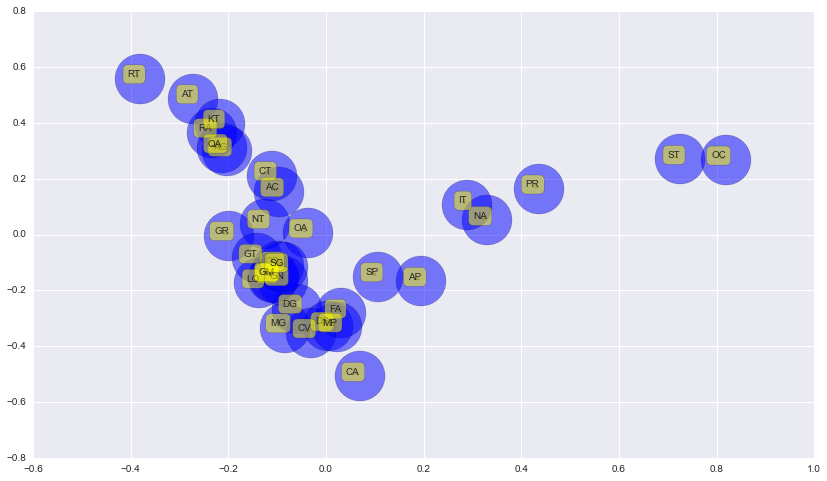

In [11]:
plt.figure(figsize=(14,8))
plt.scatter(coords_spec[:,0], coords_spec[:,1], alpha=0.5, s=2500, cmap='winter')
for label, x, y in zip(labels, coords_spec[:, 0], coords_spec[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

Use the entire data set

In [14]:
math_df = pd.read_pickle('general_math_text_titles_urls_label_df.pkl')

In [15]:
math_df.head()

,label,text,title,url
0,NA,5\n1\n0\n2\n\n \n\ng\nu\nA\n1\n\n \n\n \n \n]\...,\nTitle: An extention of Babuška-Aziz's theore...,http://lanl.arxiv.org/pdf/1508.00119
1,NA,5\n1\n0\n2\n\n \n\ng\nu\nA\n2\n\n \n\n \n \n]\...,\nTitle: Improved ZZ A Posteriori Error Estima...,http://lanl.arxiv.org/pdf/1508.00191
2,NA,A Simple Method for Computing Singular or Near...,\nTitle: A Simple Method for Computing Singula...,http://lanl.arxiv.org/pdf/1508.00265
3,NA,5\n1\n0\n2\n\n \n\ng\nu\nA\n2\n\n \n\n \n \n]\...,\nTitle: Path-space variational inference for ...,http://lanl.arxiv.org/pdf/1508.00289
4,NA,5\n1\n0\n2\n\n \n\ng\nu\nA\n3\n\n \n\n \n \n]\...,\nTitle: Galerkin finite element method for ge...,http://lanl.arxiv.org/pdf/1508.00294


In [16]:
with open('tfidf_model_and_fitted_matrix.pkl', 'r') as g:
    prediction_model, prediction_matrix = pickle.load(g)
N = prediction_matrix.todense()

In [17]:
targets = math_df['label'].values
df = pd.DataFrame(data=N)
print "Data: ", df.shape
Tar = pd.DataFrame(data=targets, columns=['label'])
print "Targets: ", Tar.shape
result = pd.concat([df, Tar], axis=1)
print "Result: ", result.shape

Data:  (9402, 10000)
Targets:  (9402, 1)
Result:  (9402, 10001)


In [18]:
class_labels = math_df['label'].unique()

Make some frames to be used in MDS

In [20]:
Dist_between_cats = np.zeros(32 * 32).reshape(32,32)

max_cat_dists = pd.DataFrame(Dist_between_cats, index=class_labels, columns=class_labels)
min_cat_dists = pd.DataFrame(Dist_between_cats, index=class_labels, columns=class_labels)
avg_cat_dists = pd.DataFrame(Dist_between_cats, index=class_labels, columns=class_labels)
for label in class_labels:
    temp_df_one = result[result['label']==label].drop('label', axis=1)
    for other_label in class_labels:
        temp_df_two = result[result['label']==other_label].drop('label', axis=1)
        min_cat_dists[label][other_label] = np.min(euclidean_distances(temp_df_one, temp_df_two))
        max_cat_dists[label][other_label] = np.max(euclidean_distances(temp_df_one, temp_df_two))
        avg_cat_dists[label][other_label] = np.mean(euclidean_distances(temp_df_one, temp_df_two))

Use different scaling features to visualize the data

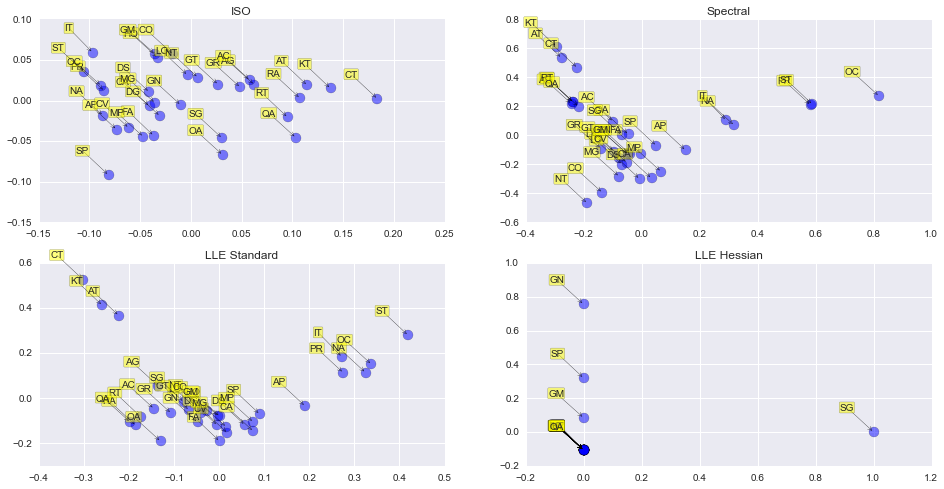

In [24]:
spec = sklman.SpectralEmbedding()
coords_spec = spec.fit_transform(avg_cat_dists)

lle = sklman.LocallyLinearEmbedding(method='standard', n_neighbors=6)
coords_lle = lle.fit_transform(avg_cat_dists)

iso = sklman.Isomap(n_components=2)
coords_iso = iso.fit_transform(avg_cat_dists)

lle2 = sklman.LocallyLinearEmbedding(method='hessian', n_neighbors=6)
coords_lle2 = lle2.fit_transform(avg_cat_dists)


f, axarr = plt.subplots(2, 2,figsize=(16,8))

axarr[0,0].scatter(coords_iso[:,0], coords_iso[:,1], alpha=0.5, s=100, cmap='winter')
for label, x, y in zip(labels, coords_iso[:, 0], coords_iso[:, 1]):
    axarr[0,0].annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
axarr[0,0].set_title("ISO")
    
axarr[1,0].scatter(coords_lle[:,0], coords_lle[:,1], alpha=0.5, s=100, cmap='winter')
for label, x, y in zip(labels, coords_lle[:, 0], coords_lle[:, 1]):
    axarr[1,0].annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
axarr[1,0].set_title("LLE Standard")

axarr[0,1].scatter(coords_spec[:,0], coords_spec[:,1], alpha=0.5, s=100, cmap='winter')
for label, x, y in zip(labels, coords_spec[:, 0], coords_spec[:, 1]):
    axarr[0,1].annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
axarr[0,1].set_title("Spectral")
    
    
axarr[1,1].scatter(coords_lle2[:,0], coords_lle2[:,1], alpha=0.5, s=100, cmap='winter')
for label, x, y in zip(labels, coords_lle2[:, 0], coords_lle2[:, 1]):
    axarr[1,1].annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
axarr[1,1].set_title("LLE Hessian")
    
plt.show()

Look at some more closely

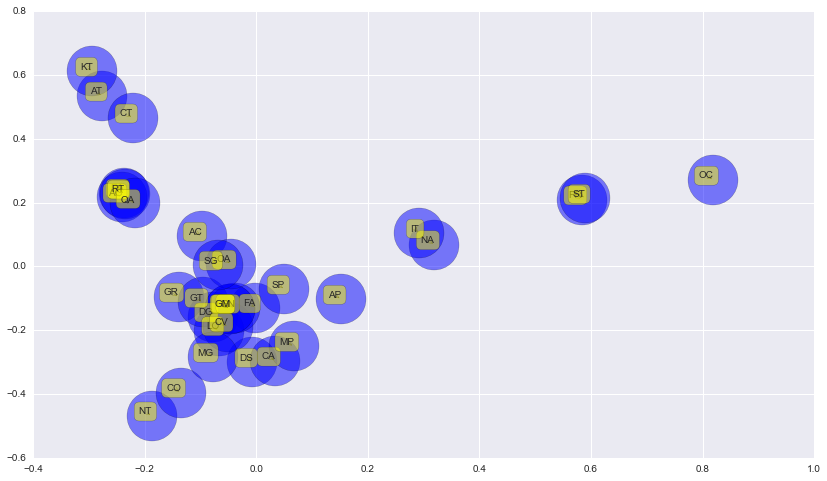

In [26]:
spec = sklman.SpectralEmbedding()
coords_spec = spec.fit_transform(min_cat_dists)
plt.figure(figsize=(14,8))
plt.scatter(coords_spec[:,0], coords_spec[:,1], alpha=0.5, s=2500, cmap='winter')
for label, x, y in zip(labels, coords_spec[:, 0], coords_spec[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

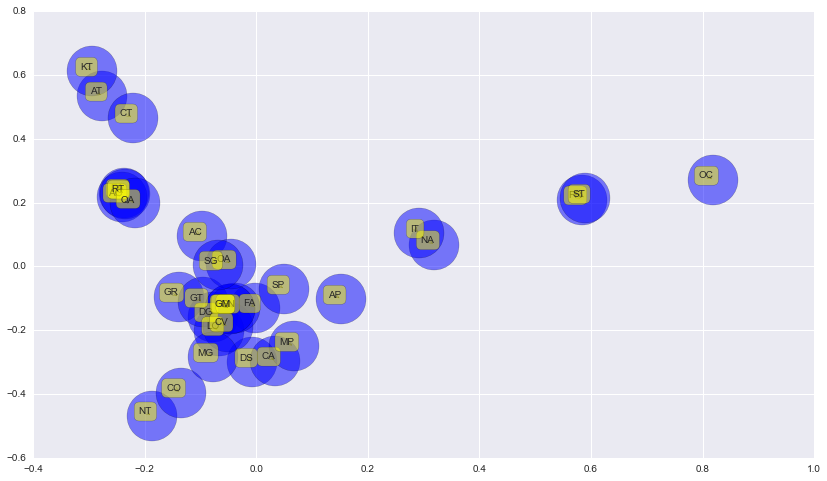

In [27]:
spec = sklman.SpectralEmbedding()
coords_spec = spec.fit_transform(avg_cat_dists)
plt.figure(figsize=(14,8))
plt.scatter(coords_spec[:,0], coords_spec[:,1], alpha=0.5, s=2500, cmap='winter')
for label, x, y in zip(labels, coords_spec[:, 0], coords_spec[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()